In [0]:
# Year of clinical trial
ct_year = str(2021)

In [0]:
fileroot = "clinicaltrial_" + ct_year

import os
os.environ ['fileroot'] = fileroot

In [0]:
%sh
rm /tmp/$fileroot.csv
rm /tmp/$fileroot.zip

rm: cannot remove '/tmp/clinicaltrial_2021.csv': No such file or directory


In [0]:
# Clean the DBFS from the contents that the notebook needs to create again

dbutils.fs.rm("/FileStore/tables/" + fileroot + ".csv", True)
dbutils.fs.rm("/FileStore/tables/pharma.csv", True)

Out[4]: True

In [0]:
dbutils.fs.cp("/FileStore/tables/" + fileroot + ".zip", "file:/tmp/")
dbutils.fs.cp("/FileStore/tables/pharma.zip", "file:/tmp/")

Out[5]: True

In [0]:
%sh
unzip -d /tmp /tmp/$fileroot.zip
unzip -d /tmp /tmp/pharma.zip

Archive:  /tmp/clinicaltrial_2021.zip
  inflating: /tmp/clinicaltrial_2021.csv  
Archive:  /tmp/pharma.zip
  inflating: /tmp/pharma.csv         


In [0]:
dbutils.fs.mv("file:/tmp/" + fileroot + ".csv", "/FileStore/tables/" + fileroot + ".csv", True )

Out[7]: True

In [0]:
dbutils.fs.mv("file:/tmp/pharma.csv", "/FileStore/tables/pharma.csv", True )

Out[8]: True

In [0]:
dbutils.fs.ls("/FileStore/tables/")

Out[9]: [FileInfo(path='dbfs:/FileStore/tables/FaultDataset-1.csv', name='FaultDataset-1.csv', size=1703184, modificationTime=1678127211000),
 FileInfo(path='dbfs:/FileStore/tables/FaultDataset-2.csv', name='FaultDataset-2.csv', size=1703184, modificationTime=1678127478000),
 FileInfo(path='dbfs:/FileStore/tables/FaultDataset-3.csv', name='FaultDataset-3.csv', size=1703184, modificationTime=1678128014000),
 FileInfo(path='dbfs:/FileStore/tables/FaultDataset-4.csv', name='FaultDataset-4.csv', size=1703184, modificationTime=1678128595000),
 FileInfo(path='dbfs:/FileStore/tables/FaultDataset-5.csv', name='FaultDataset-5.csv', size=1703184, modificationTime=1678132279000),
 FileInfo(path='dbfs:/FileStore/tables/FaultDataset.csv', name='FaultDataset.csv', size=1703184, modificationTime=1678127097000),
 FileInfo(path='dbfs:/FileStore/tables/Occupancy_Detection_Data.csv', name='Occupancy_Detection_Data.csv', size=50968, modificationTime=1677962483000),
 FileInfo(path='dbfs:/FileStore/tables/a

In [0]:
print("This is the end of the script!!!")

This is the end of the script!!!


In [0]:
from pyspark.sql import *
from pyspark.sql.functions import *
import matplotlib.pyplot as plt

In [0]:
clinicaltrial_df = spark.read.option("header","true").option("inferSchema", "true").option("delimiter", '|').csv("/FileStore/tables/clinicaltrial_" + ct_year + ".csv")

In [0]:
clinicaltrial_df.show()

+-----------+--------------------+--------------------+--------+----------+--------------------+----------+--------------------+--------------------+
|         Id|             Sponsor|              Status|   Start|Completion|                Type|Submission|          Conditions|       Interventions|
+-----------+--------------------+--------------------+--------+----------+--------------------+----------+--------------------+--------------------+
|NCT02758028|The University of...|          Recruiting|Aug 2005|  Nov 2021|      Interventional|  Apr 2016|                null|                null|
|NCT02751957|     Duke University|           Completed|Jul 2016|  Jul 2020|      Interventional|  Apr 2016|Autistic Disorder...|                null|
|NCT02758483|Universidade Fede...|           Completed|Mar 2017|  Jan 2018|      Interventional|  Apr 2016|   Diabetes Mellitus|                null|
|NCT02759848|Istanbul Medeniye...|           Completed|Jan 2012|  Dec 2014|       Observational|  Ma

In [0]:
pharma_df = spark.read.option("header","true").option("inferSchema", "true").csv("/FileStore/tables/pharma.csv")

In [0]:
# Question 1. To find the number of Distinct studies
clinicaltrial_df.distinct().count()

Out[15]: 387261

In [0]:
# Question 2. To list all the types and frequency

clinicaltrial_df.groupBy("Type").count().orderBy("count", ascending=False).show(truncate=False)

+--------------------------------+------+
|Type                            |count |
+--------------------------------+------+
|Interventional                  |301472|
|Observational                   |77540 |
|Observational [Patient Registry]|8180  |
|Expanded Access                 |69    |
+--------------------------------+------+



In [0]:
# Question 3. Top 5 conditions with their frequencies

clinicaltrial_df_freq = clinicaltrial_df.withColumn("Conditions", explode(split(col("Conditions"), ",")))

In [0]:
clinicaltrial_df_freq.show()

+-----------+--------------------+--------------------+--------+----------+--------------------+----------+--------------------+--------------------+
|         Id|             Sponsor|              Status|   Start|Completion|                Type|Submission|          Conditions|       Interventions|
+-----------+--------------------+--------------------+--------+----------+--------------------+----------+--------------------+--------------------+
|NCT02751957|     Duke University|           Completed|Jul 2016|  Jul 2020|      Interventional|  Apr 2016|   Autistic Disorder|                null|
|NCT02751957|     Duke University|           Completed|Jul 2016|  Jul 2020|      Interventional|  Apr 2016|Autism Spectrum D...|                null|
|NCT02758483|Universidade Fede...|           Completed|Mar 2017|  Jan 2018|      Interventional|  Apr 2016|   Diabetes Mellitus|                null|
|NCT02759848|Istanbul Medeniye...|           Completed|Jan 2012|  Dec 2014|       Observational|  Ma

In [0]:
# Result
clinicaltrial_df_freq.groupBy("Conditions").count().orderBy("count",ascending=False).show(5,truncate=False)

+-----------------+-----+
|Conditions       |count|
+-----------------+-----+
|Carcinoma        |13389|
|Diabetes Mellitus|11080|
|Neoplasms        |9371 |
|Breast Neoplasms |8640 |
|Syndrome         |8032 |
+-----------------+-----+
only showing top 5 rows



In [0]:
# Question 4. 10 most common sponsors that are not pharmaceutical companies, along with the number of clinical trials they have sponsored.

nonpharma_sponsor = clinicaltrial_df.join(pharma_df, pharma_df.Parent_Company == clinicaltrial_df.Sponsor, "leftanti")

In [0]:
nonpharma_sponsor.show()

+-----------+--------------------+--------------------+--------+----------+--------------------+----------+--------------------+--------------------+
|         Id|             Sponsor|              Status|   Start|Completion|                Type|Submission|          Conditions|       Interventions|
+-----------+--------------------+--------------------+--------+----------+--------------------+----------+--------------------+--------------------+
|NCT02758028|The University of...|          Recruiting|Aug 2005|  Nov 2021|      Interventional|  Apr 2016|                null|                null|
|NCT02751957|     Duke University|           Completed|Jul 2016|  Jul 2020|      Interventional|  Apr 2016|Autistic Disorder...|                null|
|NCT02758483|Universidade Fede...|           Completed|Mar 2017|  Jan 2018|      Interventional|  Apr 2016|   Diabetes Mellitus|                null|
|NCT02759848|Istanbul Medeniye...|           Completed|Jan 2012|  Dec 2014|       Observational|  Ma

In [0]:
# Result
nonpharma_sponsor.filter(nonpharma_sponsor.Status !="Active").groupBy("Sponsor").count().orderBy("count",ascending=False).show(10,truncate=False)

+---------------------------------------+-----+
|Sponsor                                |count|
+---------------------------------------+-----+
|National Cancer Institute (NCI)        |3218 |
|M.D. Anderson Cancer Center            |2414 |
|Assistance Publique - Hôpitaux de Paris|2369 |
|Mayo Clinic                            |2300 |
|Merck Sharp & Dohme Corp.              |2243 |
|Assiut University                      |2154 |
|Novartis Pharmaceuticals               |2088 |
|Massachusetts General Hospital         |1971 |
|Cairo University                       |1928 |
|Hoffmann-La Roche                      |1828 |
+---------------------------------------+-----+
only showing top 10 rows



In [0]:
# Question 5. Number of completed studies each month in a given year

completed_studies = clinicaltrial_df.filter(clinicaltrial_df.Status == "Completed")

In [0]:
completed_studies.show()

+-----------+--------------------+---------+--------+----------+--------------+----------+--------------------+--------------------+
|         Id|             Sponsor|   Status|   Start|Completion|          Type|Submission|          Conditions|       Interventions|
+-----------+--------------------+---------+--------+----------+--------------+----------+--------------------+--------------------+
|NCT02751957|     Duke University|Completed|Jul 2016|  Jul 2020|Interventional|  Apr 2016|Autistic Disorder...|                null|
|NCT02758483|Universidade Fede...|Completed|Mar 2017|  Jan 2018|Interventional|  Apr 2016|   Diabetes Mellitus|                null|
|NCT02759848|Istanbul Medeniye...|Completed|Jan 2012|  Dec 2014| Observational|  May 2016|Tuberculosis,Lung...|                null|
|NCT02757209|Consorzio Futuro ...|Completed|Apr 2016|  Jan 2018|Interventional|  Apr 2016|              Asthma|Fluticasone,Xhanc...|
|NCT02757508|Washington Univer...|Completed|Mar 2016|  Jul 2017|Inter

In [0]:
# Selecting completed studies by year

completed_studies_year = completed_studies.filter(completed_studies.Completion.endswith(ct_year)).withColumn('Completion', substring('Completion', 1,3))

In [0]:
completed_studies_year.show()

+-----------+--------------------+---------+--------+----------+--------------------+----------+--------------------+--------------------+
|         Id|             Sponsor|   Status|   Start|Completion|                Type|Submission|          Conditions|       Interventions|
+-----------+--------------------+---------+--------+----------+--------------------+----------+--------------------+--------------------+
|NCT02753530|           Orphazyme|Completed|Aug 2017|       Jan|      Interventional|  Apr 2016|            Myositis|                null|
|NCT02758704|St. Justine's Hos...|Completed|Oct 2015|       Jun|      Interventional|  Apr 2016|                null|                null|
|NCT02754778|Martin-Luther-Uni...|Completed|Apr 2016|       Mar|      Interventional|  Apr 2016|Pre-Eclampsia,HEL...|                null|
|NCT02758782|Charite Universit...|Completed|Sep 2016|       Jan|      Interventional|  Apr 2016|         Spondylitis| Celecoxib,Golimumab|
|NCT02751151|Inova Health C

In [0]:
studies = completed_studies_year.groupBy("Completion").count().sort(unix_timestamp(completed_studies_year.Completion,"MMM"))

In [0]:
# Result
studies.show()

+----------+-----+
|Completion|count|
+----------+-----+
|       Jan| 1131|
|       Feb|  934|
|       Mar| 1227|
|       Apr|  967|
|       May|  984|
|       Jun| 1094|
|       Jul|  819|
|       Aug|  700|
|       Sep|  528|
|       Oct|  187|
+----------+-----+



In [0]:
completion_months = studies.select("Completion").rdd.map(lambda line: line["Completion"]).collect()

count_per_month = studies.select("count").rdd.map(lambda line: line["count"]).collect()

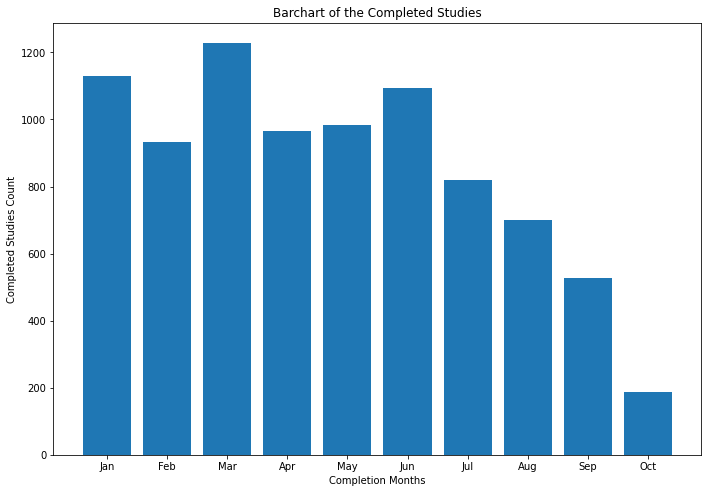

In [0]:
# Visualizing the completed studies
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.bar(completion_months,count_per_month)

plt.xlabel("Completion Months")
plt.ylabel("Completed Studies Count")
plt.title("Barchart of the Completed Studies")

plt.show()

FURTHER ANALYSIS - Distribution of trial status by study type.

In [0]:
# Step 1: Create a temporary view for the clinical trials DataFrame
clinicaltrial_df.createOrReplaceTempView("trials_view")

# Step 2: Group trials by study type and status, and count the number of trials using SQL
status_by_type_sql = """
SELECT Type, Status, COUNT(*) as TrialCount
FROM trials_view
GROUP BY Type, Status
ORDER BY Type, Status
"""

# Step 3: Execute the query and collect the result
status_by_type_df = spark.sql(status_by_type_sql)

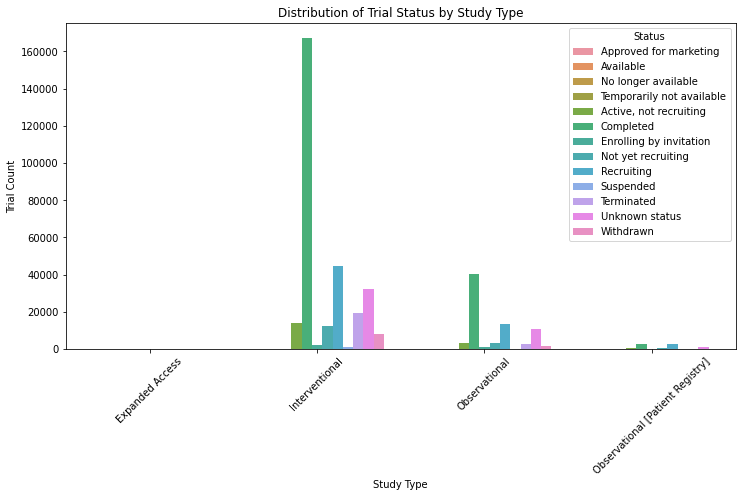

In [0]:
# Step 4: Visualize the result as a stacked bar chart

#Convert the result to Pandas Dataframe for visualization
status_by_type_pd = status_by_type_df.toPandas()

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.barplot(x="Type", y="TrialCount", hue="Status", data=status_by_type_pd)
plt.title("Distribution of Trial Status by Study Type")
plt.xlabel("Study Type")
plt.ylabel("Trial Count")
plt.xticks(rotation=45)
plt.legend(title="Status", loc="upper right")
plt.show()